In [6]:
#CREMA-D

# IMPORT

In [7]:
import os
import random
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from src.visual_analysys_cremad.visual_analysys_cremad import (
    extract_crnn_embeddings,
    tsne_project,
    plot_fold_summary,
    gradcam_summary,
)

from src.preprocessing.dataset import (
    list_cremad_files,
    CremadDataset,
    extract_cremad_label_idx,
    CREMA_IDX2LABEL,
    parse_cremad_filename,
)

# DEFINIZIONE DATA BASE CREMA-D

In [11]:
set_seed(42)

DATA_ROOT = "./data_cremad"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

N_FOLDS = 6
N_MELS = 64

device = "cuda" if torch.cuda.is_available() else "cpu"
PIN = torch.cuda.is_available()
print("Device:", device)

all_files = list_cremad_files(DATA_ROOT)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT.")

labels = [extract_cremad_label_idx(fp) for fp in all_files]
speakers = [parse_cremad_filename(fp)["speaker"] for fp in all_files]

print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))
print("Numero speakers unici:", len(set(speakers)))

Device: cuda
Tot files: 7442
Distribuzione classi: Counter({3: 1271, 5: 1271, 4: 1271, 1: 1271, 2: 1271, 0: 1087})
Numero speakers unici: 91


# SPLIT DATASET

In [12]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
AUG_ON = True
aug_cfg = {
    "gain": True,
    "gain_db": (-3, 3),

    "time_shift": True,
    "time_shift_s": 0.03,

    "noise": True,
    "snr_db": (25, 40),
    "vtlp": False,

    "reverb": True,
    "reverb_ir_s": 0.04,
    "reverb_decay": 0.25,
}

print(f"\n{'='*60}")
print(f"CROSS-VALIDATION CON {N_FOLDS} FOLDS (SPEAKER-INDEPENDENT) - CREMA-D")
print(f"{'='*60}\n")

gkf = GroupKFold(n_splits=N_FOLDS)
fold_results = []

# ----------------------------
# LOOP FOLDS: training completo
# ----------------------------
for fold_idx, (train_val_idx, test_idx) in enumerate(gkf.split(all_files, labels, groups=speakers)):

    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx + 1}/{N_FOLDS}")
    print(f"{'='*60}")

    # A) split fold
    test_files = [all_files[i] for i in test_idx]
    train_val_files = [all_files[i] for i in train_val_idx]

    train_val_speakers = [speakers[i] for i in train_val_idx]
    train_val_labels = [labels[i] for i in train_val_idx]
    test_speakers = sorted(set([speakers[i] for i in test_idx]))

    # B) split train/val speaker-independent
    unique_tv_spk = list(set(train_val_speakers))
    random.seed(42 + fold_idx)

    val_size = max(2, len(unique_tv_spk) // 6)
    val_speakers = random.sample(unique_tv_spk, k=min(val_size, len(unique_tv_spk)))
    train_speakers = [s for s in unique_tv_spk if s not in val_speakers]

    train_files = [f for f, s in zip(train_val_files, train_val_speakers) if s in train_speakers]
    val_files   = [f for f, s in zip(train_val_files, train_val_speakers) if s in val_speakers]

    print(f"Train: {len(train_files)} files, {len(train_speakers)} speakers")
    print(f"Val:   {len(val_files)} files, {len(val_speakers)} speakers")
    print(f"Test:  {len(test_files)} files, {len(test_speakers)} speakers -> {test_speakers}")

    # C) class weights (6 classi) con eps anti-missing-class
    train_labels_fold = [extract_cremad_label_idx(fp) for fp in train_files]
    counts = Counter(train_labels_fold)

    eps = 1e-6
    weights = torch.tensor(
        [1.0 / (counts.get(i, 0) + eps) for i in range(6)],
        dtype=torch.float,
        device=device
    )
    weights = weights / weights.sum() * 6

    print(f"Class counts: {counts}")
    print(f"Weights: {weights.detach().cpu().numpy().round(3)}")

    # D) dataset + dataloader
    train_ds = CremadDataset(train_files, n_mels=N_MELS, augmentation=AUG_ON, aug_config=aug_cfg)
    val_ds   = CremadDataset(val_files,   n_mels=N_MELS, augmentation=False)
    test_ds  = CremadDataset(test_files,  n_mels=N_MELS, augmentation=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=PIN)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN)

    # E) model / optimizer / scheduler
    model = CRNN(n_classes=6, n_mels=N_MELS).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=6
    )

    best_val_acc = 0.0
    
    best_path = f"best_fold_{fold_idx}.pt"
    torch.save(model.state_dict(), best_path)  # checkpoint iniziale

    val_acc_hist = []
    test_acc_hist = []

    print(f"\nInizio training fold {fold_idx + 1}...")

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x)

            loss = torch.nn.functional.cross_entropy(logits, y, weight=weights)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            running_loss += loss.item() * y.size(0)
            running_correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        val_loss, val_acc = evaluate(model, val_loader, device)
        test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)

        scheduler.step(val_acc)

        val_acc_hist.append(val_acc)
        test_acc_hist.append(test_acc_epoch)

        if epoch % 5 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:3d}/{EPOCHS} | "
                f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
                f"test acc {test_acc_epoch:.4f}"
            )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)

    # F) valutazione finale fold (best checkpoint)
    model.load_state_dict(torch.load(best_path, map_location=device))
    final_test_loss, final_test_acc = evaluate(model, test_loader, device)

    print(f"\n{'='*60}")
    print(f"RISULTATI FOLD {fold_idx + 1}")
    print(f"{'='*60}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy:      {final_test_acc:.4f}")

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x).cpu()
            preds = logits.argmax(dim=1).numpy().tolist()
            y_pred.extend(preds)
            y_true.extend(y.numpy().tolist())

    target_names = [CREMA_IDX2LABEL[i] for i in range(6)]
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    fold_results.append({
        "fold": fold_idx,
        "test_speakers": test_speakers,
        "val_speakers": sorted(val_speakers),
        "train_speakers": sorted(train_speakers),
        "best_val_acc": best_val_acc,
        "final_test_acc": final_test_acc,
        "val_acc_history": val_acc_hist,
        "test_acc_history": test_acc_hist,
        "y_true": y_true,
        "y_pred": y_pred,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
    })

        


CROSS-VALIDATION CON 6 FOLDS (SPEAKER-INDEPENDENT) - CREMA-D


FOLD 1/6
Train: 5234 files, 64 speakers
Val:   978 files, 12 speakers
Test:  1230 files, 15 speakers -> ['1006', '1013', '1018', '1025', '1031', '1037', '1043', '1049', '1055', '1061', '1067', '1072', '1079', '1085', '1091']
Class counts: Counter({3: 894, 5: 894, 4: 894, 1: 894, 2: 894, 0: 764})
Weights: [1.138 0.972 0.972 0.972 0.972 0.972]

Inizio training fold 1...
Epoch   1/50 | train loss 1.5769 acc 0.3477 | val loss 1.5166 acc 0.3885 | test acc 0.4057
Epoch   5/50 | train loss 1.3288 acc 0.4700 | val loss 1.3365 acc 0.4826 | test acc 0.4797
Epoch  10/50 | train loss 1.1531 acc 0.5558 | val loss 1.2394 acc 0.5164 | test acc 0.5439
Epoch  15/50 | train loss 1.0186 acc 0.6066 | val loss 1.1275 acc 0.5838 | test acc 0.5813
Epoch  20/50 | train loss 0.8758 acc 0.6666 | val loss 1.0831 acc 0.6002 | test acc 0.6016
Epoch  25/50 | train loss 0.7625 acc 0.7195 | val loss 1.0298 acc 0.6186 | test acc 0.6276
Epoch  30/50 | trai

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 1
Best Validation Accuracy: 0.6534
Final Test Accuracy:      0.6610

Classification Report:
              precision    recall  f1-score   support

     neutral     0.7384    0.7056    0.7216       180
       happy     0.6450    0.6143    0.6293       210
         sad     0.6083    0.6952    0.6489       210
       angry     0.7757    0.7905    0.7830       210
     fearful     0.5094    0.6476    0.5702       210
     disgust     0.7956    0.5190    0.6282       210

    accuracy                         0.6610      1230
   macro avg     0.6787    0.6620    0.6635      1230
weighted avg     0.6773    0.6610    0.6621      1230


FOLD 2/6
Train: 5235 files, 64 speakers
Val:   977 files, 12 speakers
Test:  1230 files, 15 speakers -> ['1004', '1012', '1017', '1024', '1030', '1036', '1042', '1048', '1054', '1060', '1065', '1068', '1078', '1084', '1090']
Class counts: Counter({3: 894, 5: 894, 4: 894, 1: 894, 2: 894, 0: 765})
Weights: [1.137 0.973 0.973 0.973 0.973 0.973]

Ini

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 2
Best Validation Accuracy: 0.6285
Final Test Accuracy:      0.6163

Classification Report:
              precision    recall  f1-score   support

     neutral     0.5891    0.6611    0.6230       180
       happy     0.5178    0.7619    0.6166       210
         sad     0.5356    0.6810    0.5996       210
       angry     0.7865    0.7190    0.7512       210
     fearful     0.7258    0.4286    0.5389       210
     disgust     0.6985    0.4524    0.5491       210

    accuracy                         0.6163      1230
   macro avg     0.6422    0.6173    0.6131      1230
weighted avg     0.6435    0.6163    0.6128      1230


FOLD 3/6
Train: 5235 files, 64 speakers
Val:   978 files, 12 speakers
Test:  1229 files, 15 speakers -> ['1011', '1016', '1023', '1029', '1035', '1041', '1047', '1053', '1059', '1064', '1071', '1076', '1077', '1083', '1089']
Class counts: Counter({3: 894, 5: 894, 4: 894, 1: 894, 2: 894, 0: 765})
Weights: [1.137 0.973 0.973 0.973 0.973 0.973]

Ini

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 3
Best Validation Accuracy: 0.6288
Final Test Accuracy:      0.6461

Classification Report:
              precision    recall  f1-score   support

     neutral     0.6256    0.7654    0.6884       179
       happy     0.6600    0.4714    0.5500       210
         sad     0.6513    0.6048    0.6272       210
       angry     0.6679    0.8429    0.7453       210
     fearful     0.6667    0.6286    0.6471       210
     disgust     0.6040    0.5810    0.5922       210

    accuracy                         0.6461      1229
   macro avg     0.6459    0.6490    0.6417      1229
weighted avg     0.6464    0.6461    0.6405      1229


FOLD 4/6
Train: 5229 files, 64 speakers
Val:   984 files, 12 speakers
Test:  1229 files, 15 speakers -> ['1002', '1003', '1010', '1022', '1028', '1032', '1034', '1040', '1046', '1052', '1058', '1070', '1075', '1082', '1088']
Class counts: Counter({3: 893, 5: 893, 4: 893, 1: 893, 2: 893, 0: 764})
Weights: [1.137 0.973 0.973 0.973 0.973 0.973]

Ini

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 4
Best Validation Accuracy: 0.6931
Final Test Accuracy:      0.6127

Classification Report:
              precision    recall  f1-score   support

     neutral     0.6852    0.6201    0.6510       179
       happy     0.6648    0.5667    0.6118       210
         sad     0.5187    0.5952    0.5543       210
       angry     0.7342    0.7762    0.7546       210
     fearful     0.5507    0.5952    0.5721       210
     disgust     0.5556    0.5238    0.5392       210

    accuracy                         0.6127      1229
   macro avg     0.6182    0.6129    0.6139      1229
weighted avg     0.6165    0.6127    0.6129      1229


FOLD 5/6
Train: 5164 files, 63 speakers
Val:   978 files, 12 speakers
Test:  1300 files, 16 speakers -> ['1007', '1008', '1015', '1019', '1021', '1027', '1033', '1039', '1045', '1051', '1057', '1063', '1069', '1074', '1081', '1087']
Class counts: Counter({3: 882, 5: 882, 4: 882, 1: 882, 2: 882, 0: 754})
Weights: [1.138 0.972 0.972 0.972 0.972 0.9

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 5
Best Validation Accuracy: 0.6933
Final Test Accuracy:      0.6185

Classification Report:
              precision    recall  f1-score   support

     neutral     0.7000    0.6632    0.6811       190
       happy     0.6592    0.5315    0.5885       222
         sad     0.5607    0.6036    0.5813       222
       angry     0.7424    0.7658    0.7539       222
     fearful     0.5075    0.6081    0.5533       222
     disgust     0.5845    0.5450    0.5641       222

    accuracy                         0.6185      1300
   macro avg     0.6257    0.6195    0.6204      1300
weighted avg     0.6239    0.6185    0.6189      1300


FOLD 6/6
Train: 5234 files, 64 speakers
Val:   984 files, 12 speakers
Test:  1224 files, 15 speakers -> ['1001', '1005', '1009', '1014', '1020', '1026', '1038', '1044', '1050', '1056', '1062', '1066', '1073', '1080', '1086']
Class counts: Counter({3: 894, 5: 894, 4: 894, 1: 894, 2: 894, 0: 764})
Weights: [1.138 0.972 0.972 0.972 0.972 0.972]

Ini

C:\Users\franc\AppData\Local\Temp\ipykernel_26812\3127051802.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=d


RISULTATI FOLD 6
Best Validation Accuracy: 0.6717
Final Test Accuracy:      0.6454

Classification Report:
              precision    recall  f1-score   support

     neutral     0.6753    0.7318    0.7024       179
       happy     0.6172    0.6172    0.6172       209
         sad     0.6974    0.5072    0.5873       209
       angry     0.7321    0.7847    0.7575       209
     fearful     0.6332    0.6029    0.6176       209
     disgust     0.5447    0.6411    0.5890       209

    accuracy                         0.6454      1224
   macro avg     0.6500    0.6475    0.6452      1224
weighted avg     0.6494    0.6454    0.6438      1224




RISULTATI FINALI CROSS-VALIDATION (6 FOLDS) - CREMA-D

Risultati per fold:
Fold   Val Acc    Test Acc   Test Speakers
----------------------------------------------------------------------
1      0.6534     0.6610     ['1006', '1013', '1018', '1025', '1031', '1037', '1043', '1049', '1055', '1061', '1067', '1072', '1079', '1085', '1091']
2      0.6285     0.6163     ['1004', '1012', '1017', '1024', '1030', '1036', '1042', '1048', '1054', '1060', '1065', '1068', '1078', '1084', '1090']
3      0.6288     0.6461     ['1011', '1016', '1023', '1029', '1035', '1041', '1047', '1053', '1059', '1064', '1071', '1076', '1077', '1083', '1089']
4      0.6931     0.6127     ['1002', '1003', '1010', '1022', '1028', '1032', '1034', '1040', '1046', '1052', '1058', '1070', '1075', '1082', '1088']
5      0.6933     0.6185     ['1007', '1008', '1015', '1019', '1021', '1027', '1033', '1039', '1045', '1051', '1057', '1063', '1069', '1074', '1081', '1087']
6      0.6717     0.6454     ['1001', '1005', '1009'

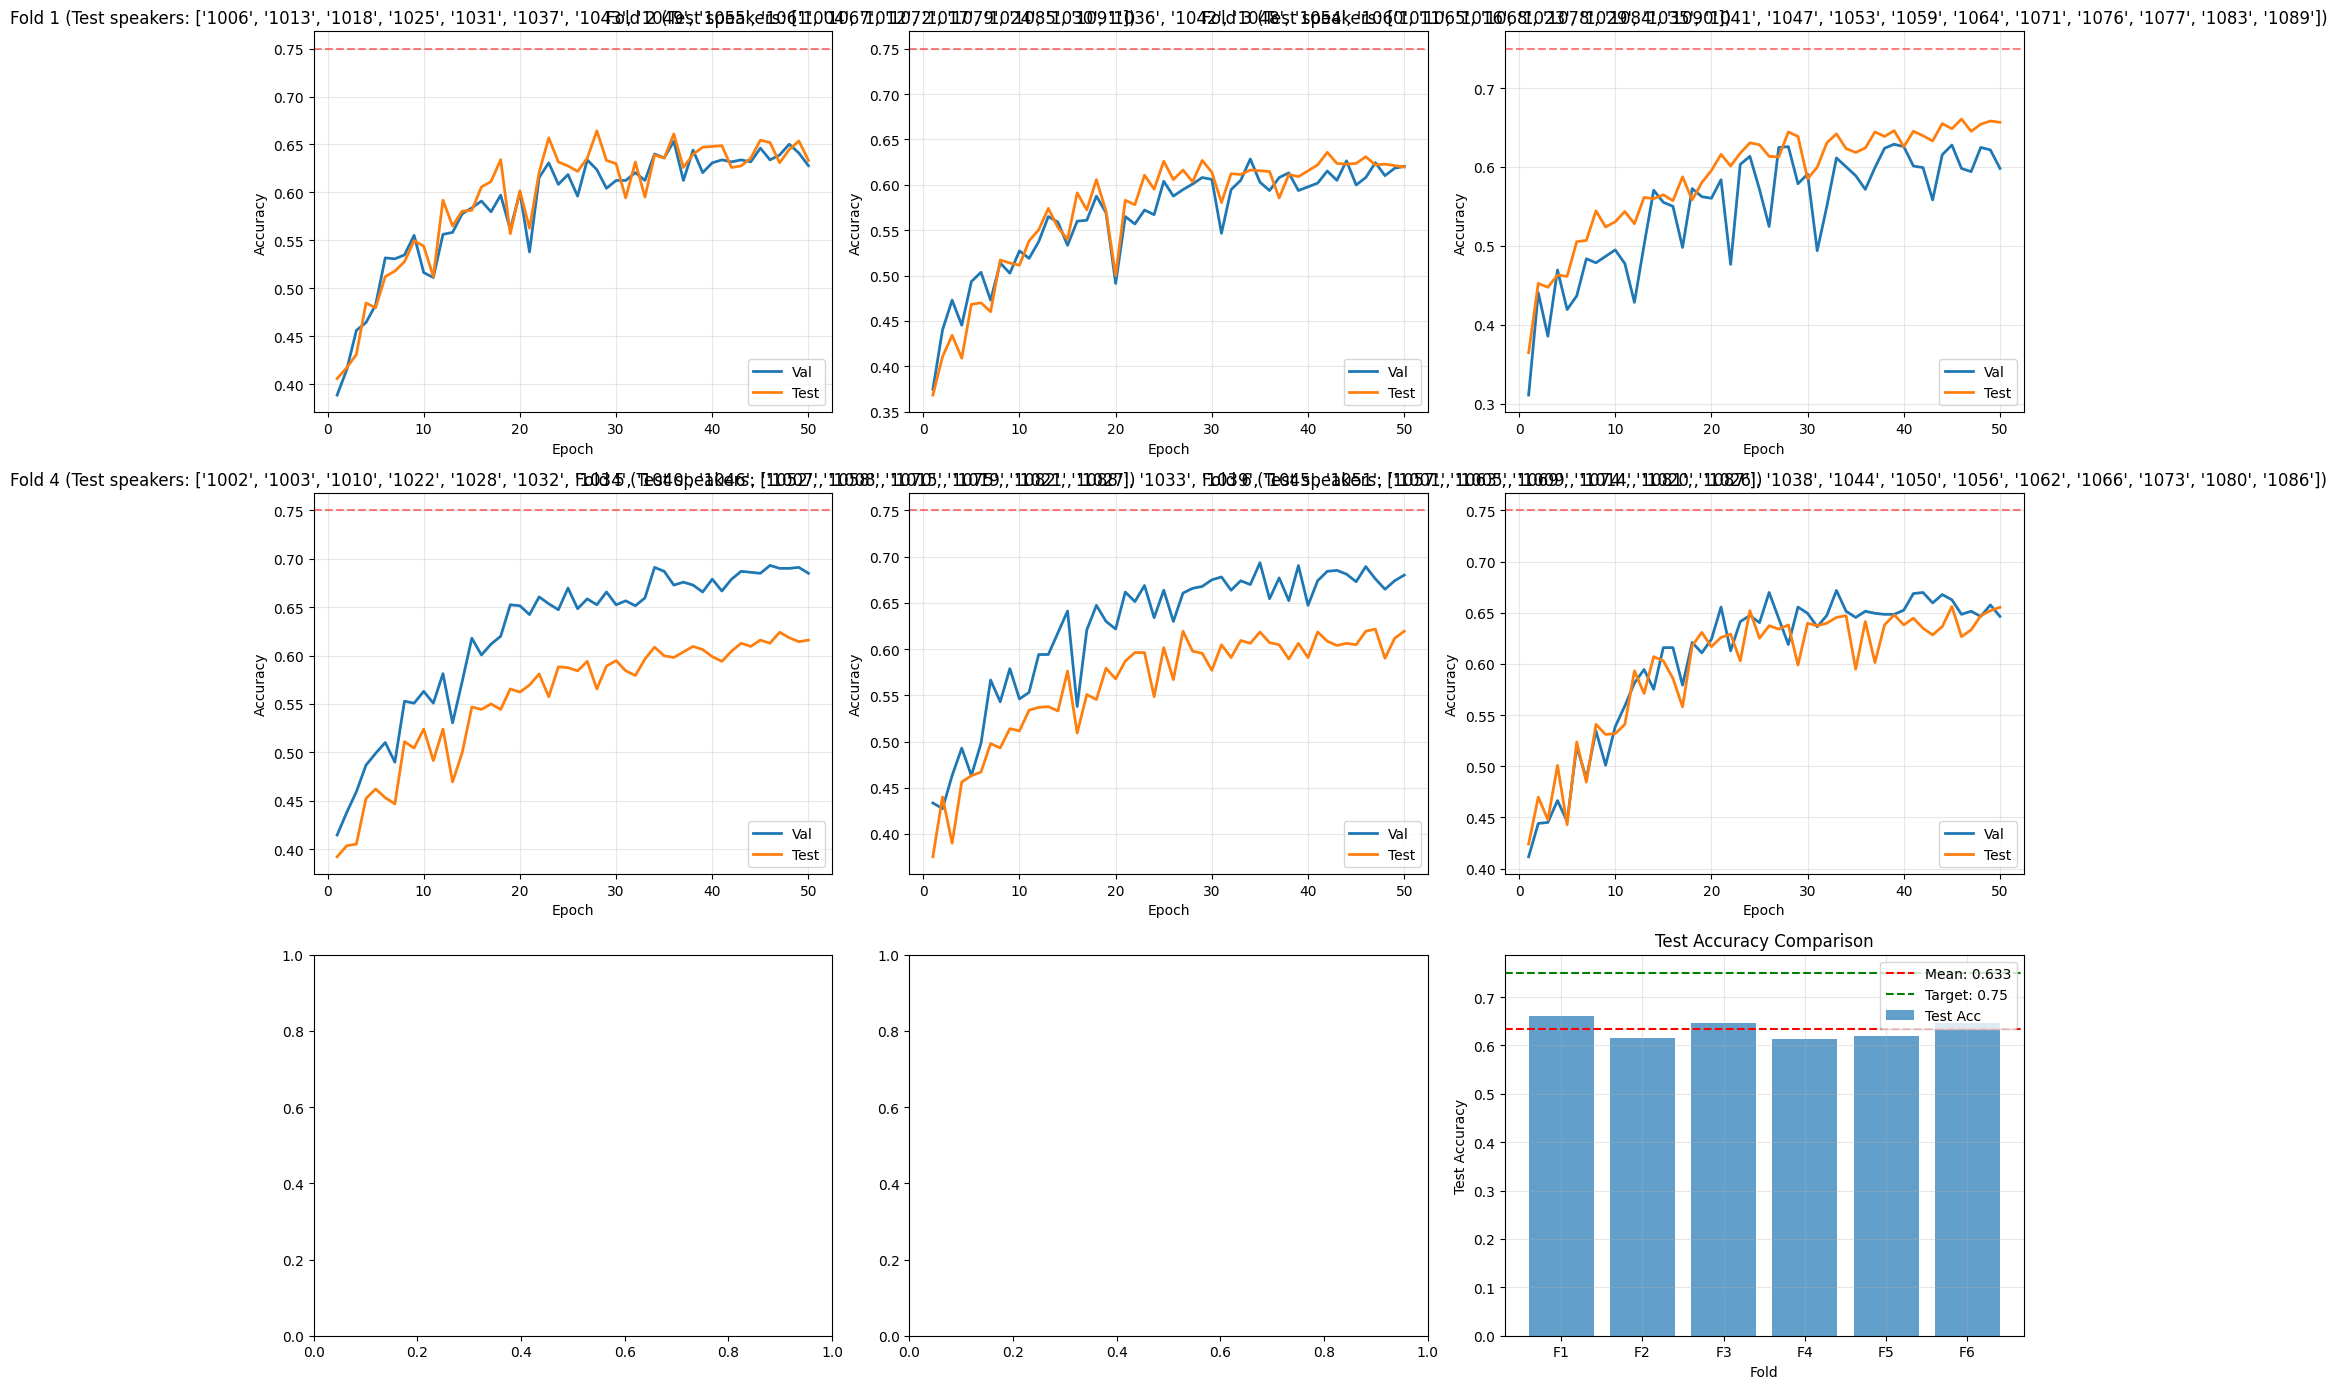

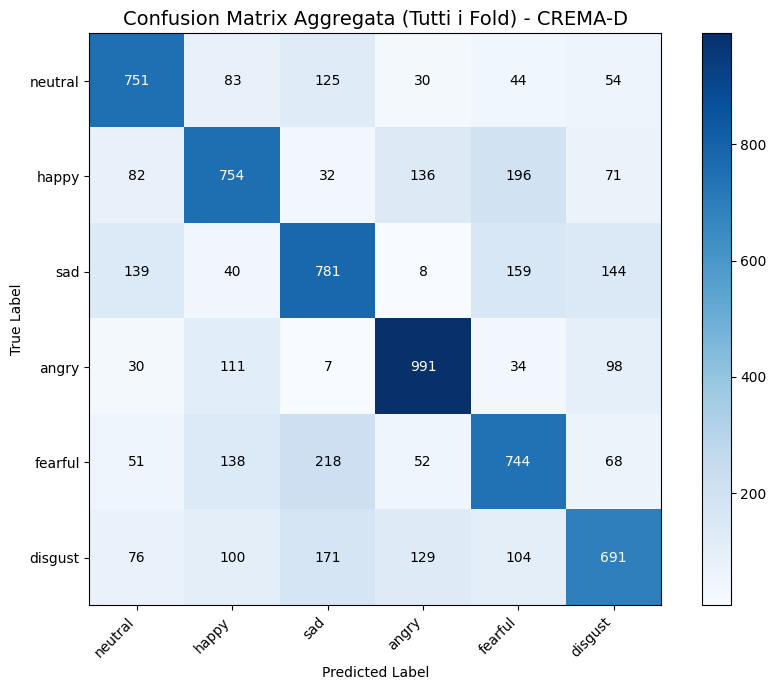


Classification Report Aggregato (Tutti i Fold) - CREMA-D:
              precision    recall  f1-score   support

     neutral     0.6652    0.6909    0.6778      1087
       happy     0.6150    0.5932    0.6039      1271
         sad     0.5855    0.6145    0.5996      1271
       angry     0.7363    0.7797    0.7574      1271
     fearful     0.5808    0.5854    0.5831      1271
     disgust     0.6137    0.5437    0.5766      1271

    accuracy                         0.6332      7442
   macro avg     0.6327    0.6346    0.6331      7442
weighted avg     0.6319    0.6332    0.6319      7442


VISUAL ANALYSIS (t-SNE + Grad-CAM) - CREMA-D

VISUAL ANALYSIS – CREMA-D – FOLD 1


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

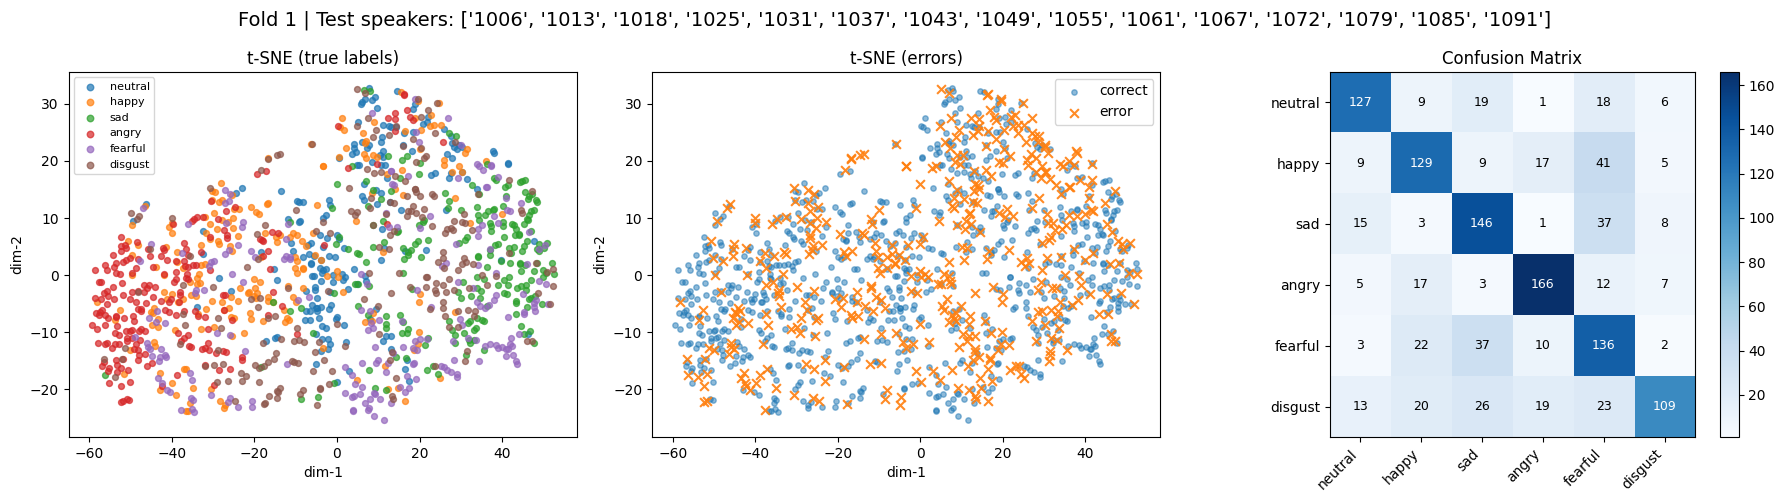

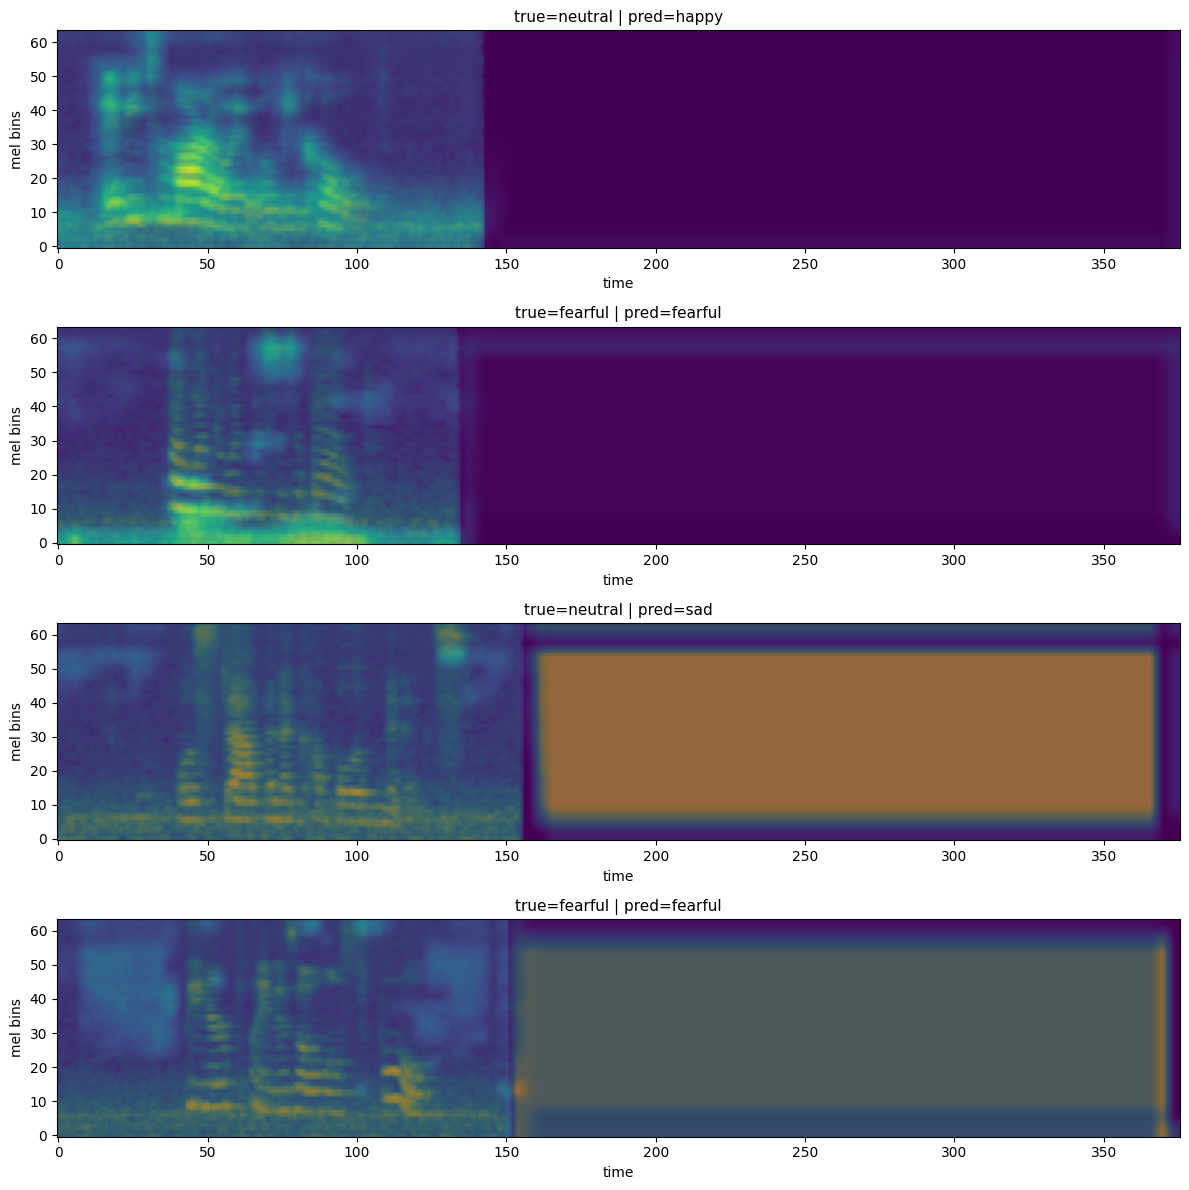


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.7384    0.7056    0.7216       180
       happy     0.6450    0.6143    0.6293       210
         sad     0.6083    0.6952    0.6489       210
       angry     0.7757    0.7905    0.7830       210
     fearful     0.5094    0.6476    0.5702       210
     disgust     0.7956    0.5190    0.6282       210

    accuracy                         0.6610      1230
   macro avg     0.6787    0.6620    0.6635      1230
weighted avg     0.6773    0.6610    0.6621      1230


VISUAL ANALYSIS – CREMA-D – FOLD 2


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

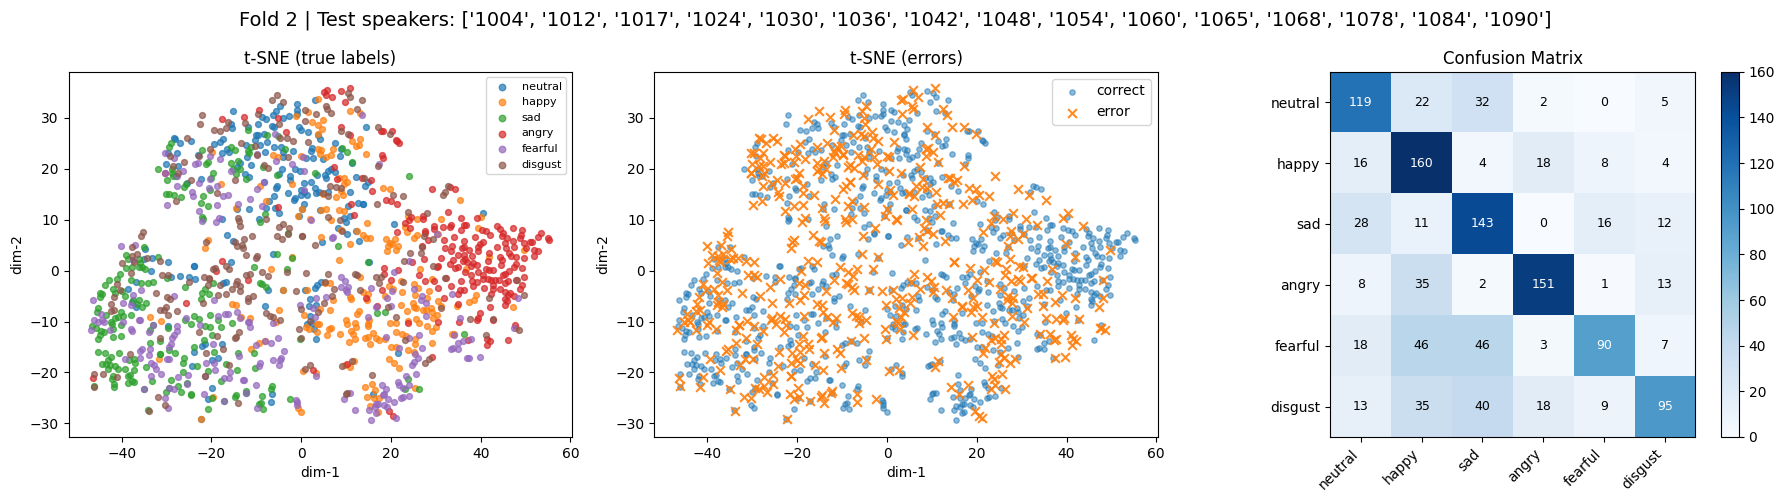

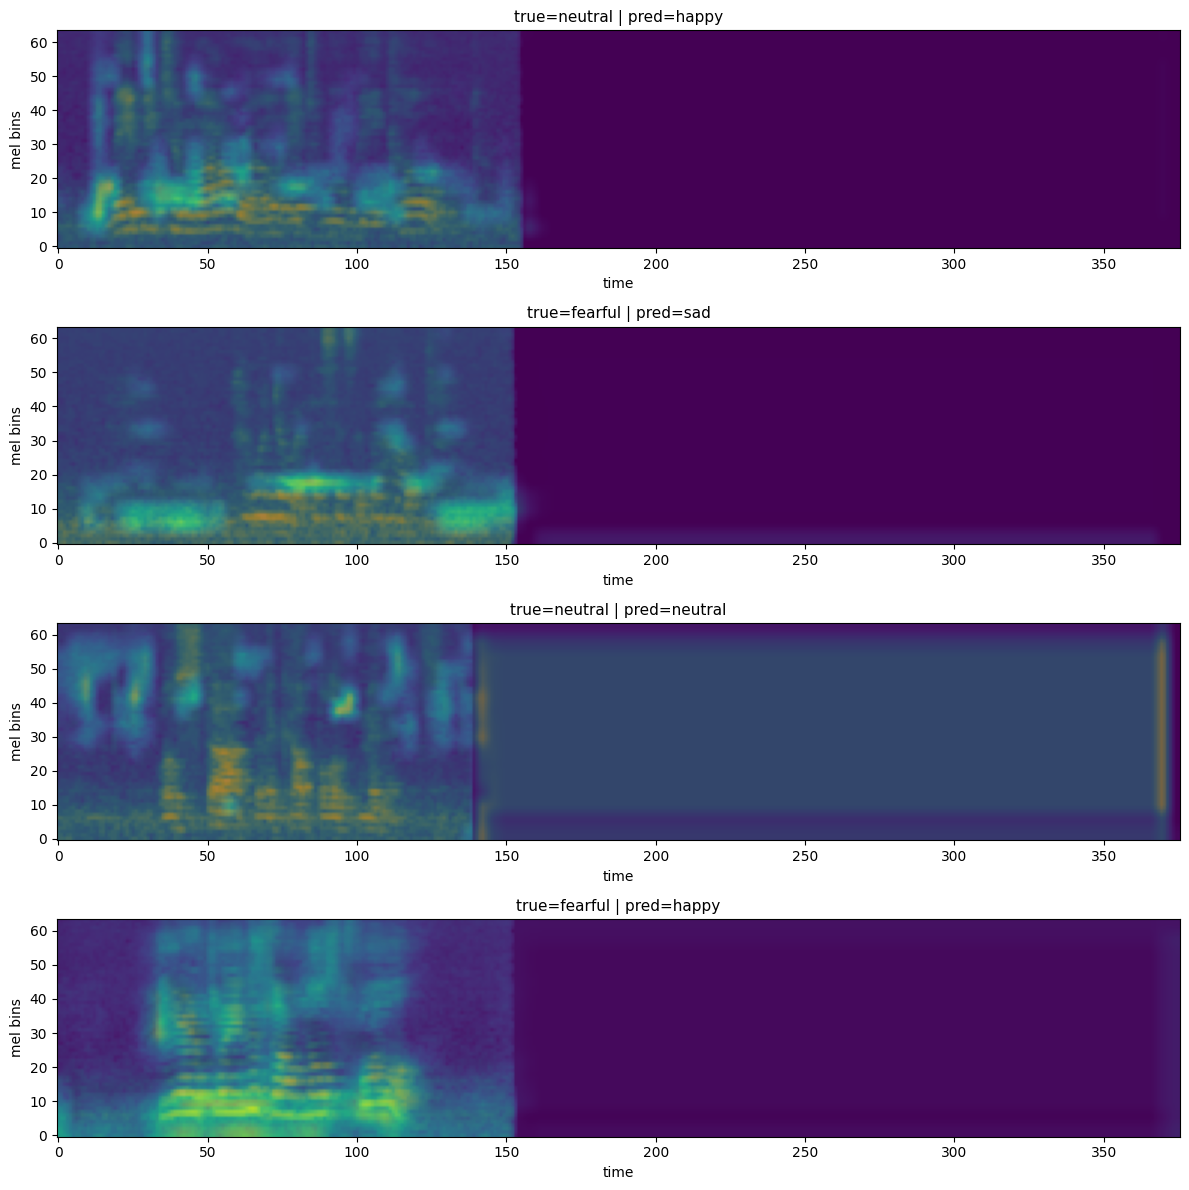


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.5891    0.6611    0.6230       180
       happy     0.5178    0.7619    0.6166       210
         sad     0.5356    0.6810    0.5996       210
       angry     0.7865    0.7190    0.7512       210
     fearful     0.7258    0.4286    0.5389       210
     disgust     0.6985    0.4524    0.5491       210

    accuracy                         0.6163      1230
   macro avg     0.6422    0.6173    0.6131      1230
weighted avg     0.6435    0.6163    0.6128      1230


VISUAL ANALYSIS – CREMA-D – FOLD 3


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

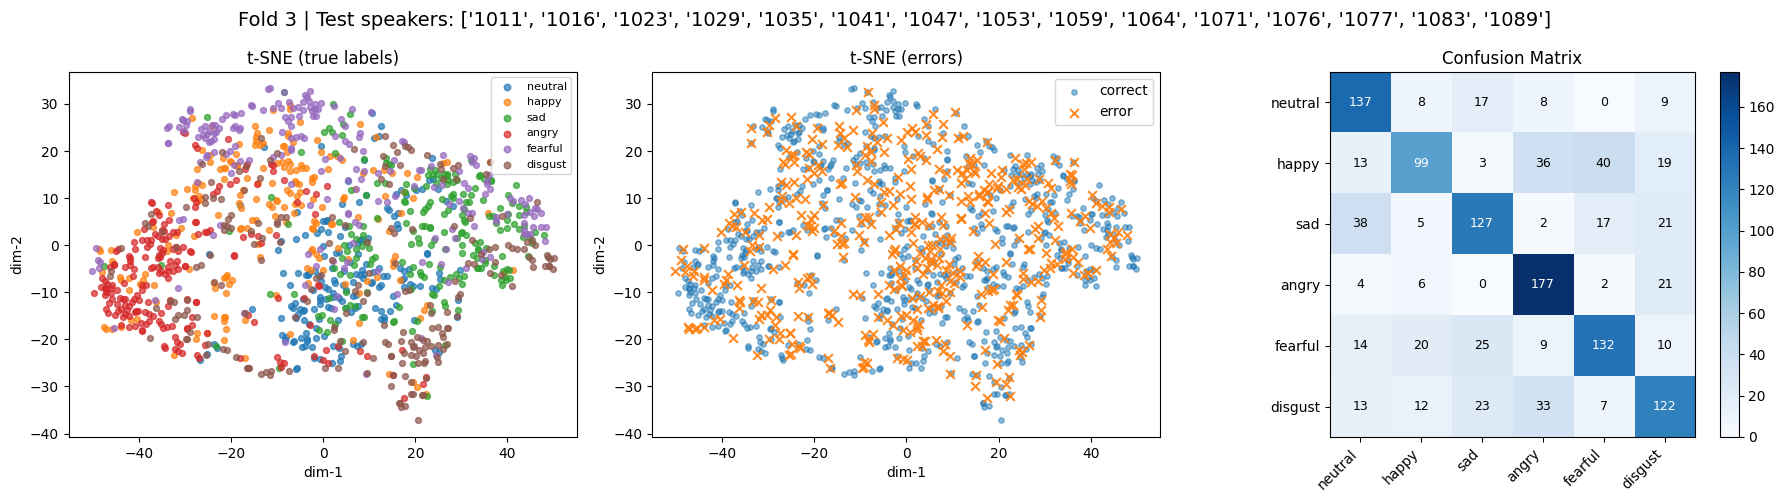

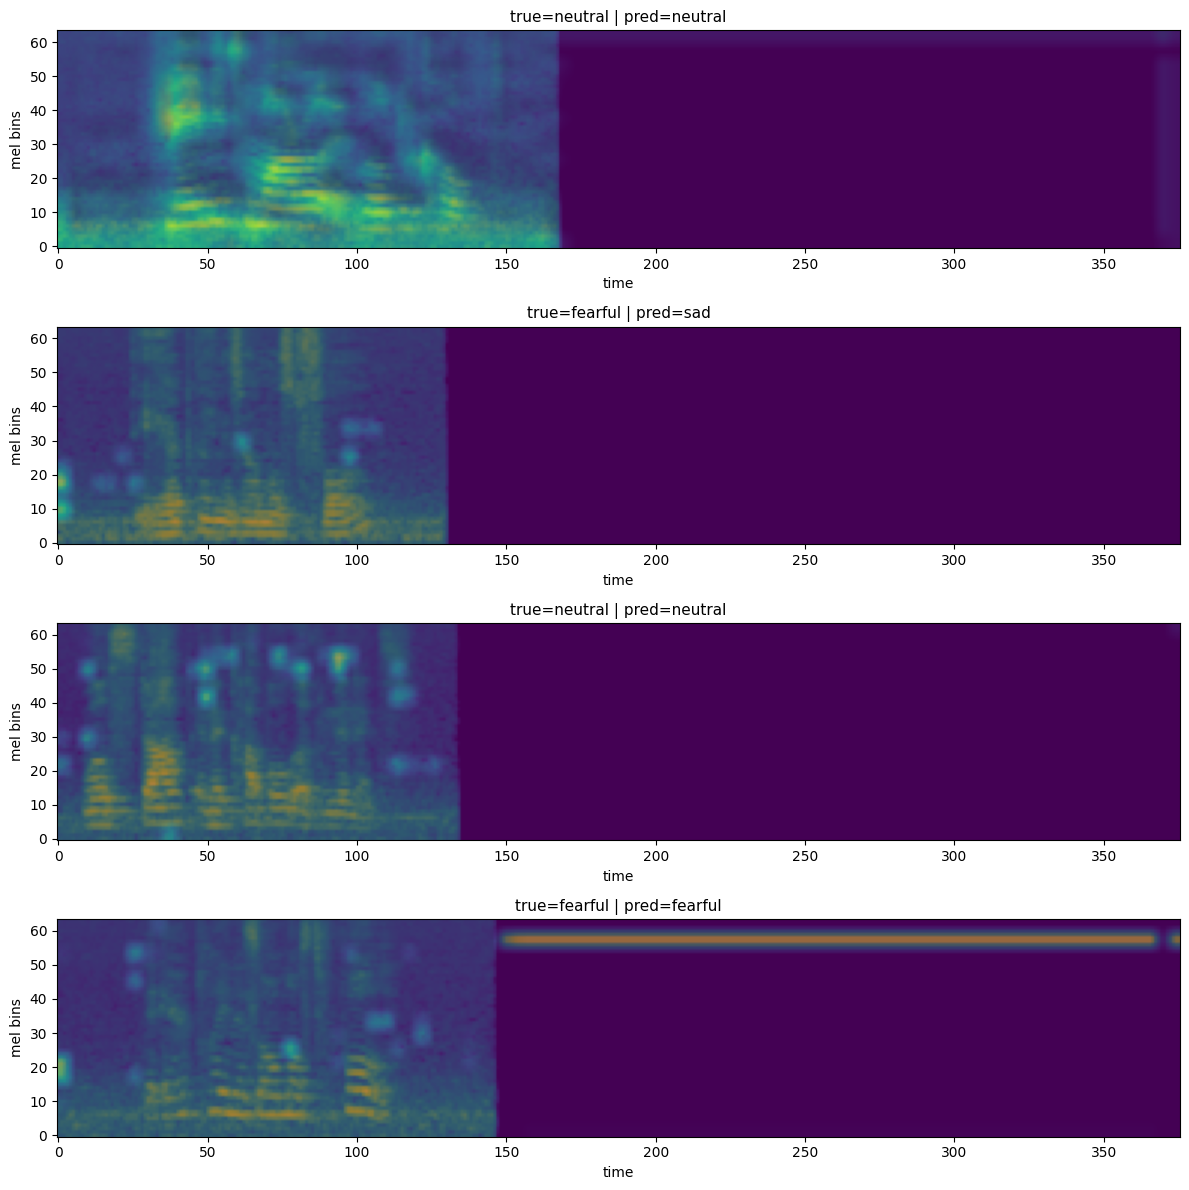


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.6256    0.7654    0.6884       179
       happy     0.6600    0.4714    0.5500       210
         sad     0.6513    0.6048    0.6272       210
       angry     0.6679    0.8429    0.7453       210
     fearful     0.6667    0.6286    0.6471       210
     disgust     0.6040    0.5810    0.5922       210

    accuracy                         0.6461      1229
   macro avg     0.6459    0.6490    0.6417      1229
weighted avg     0.6464    0.6461    0.6405      1229


VISUAL ANALYSIS – CREMA-D – FOLD 4


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

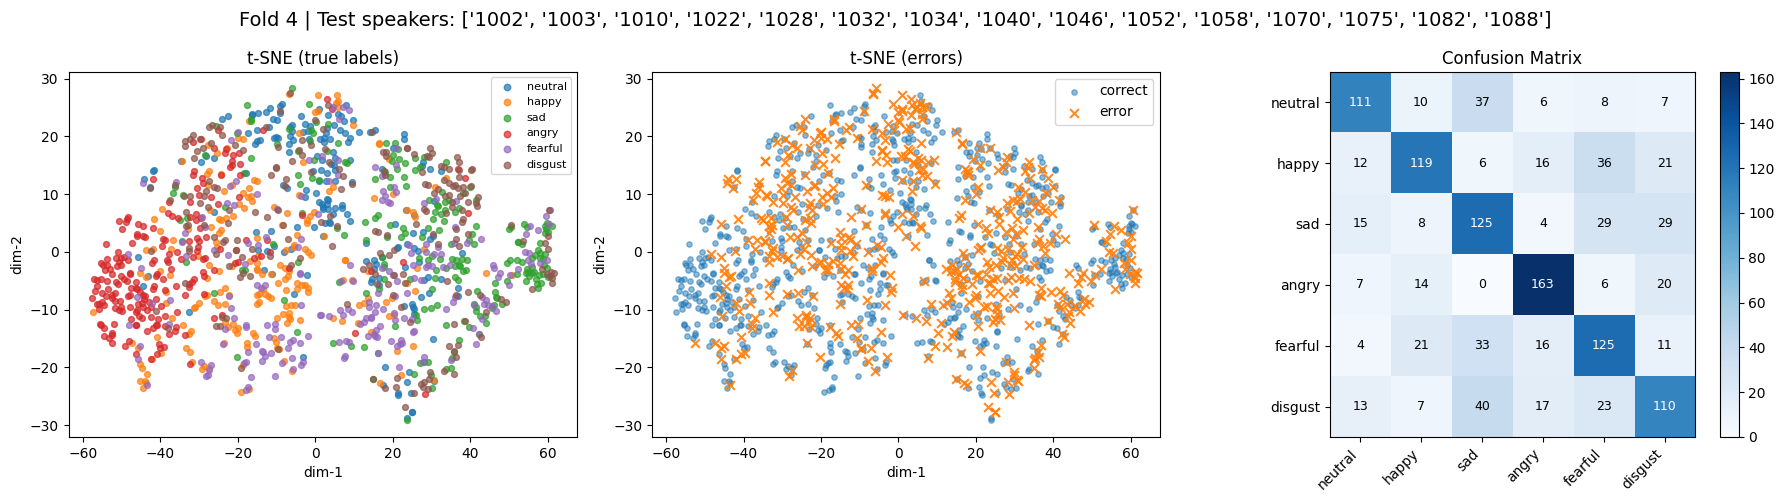

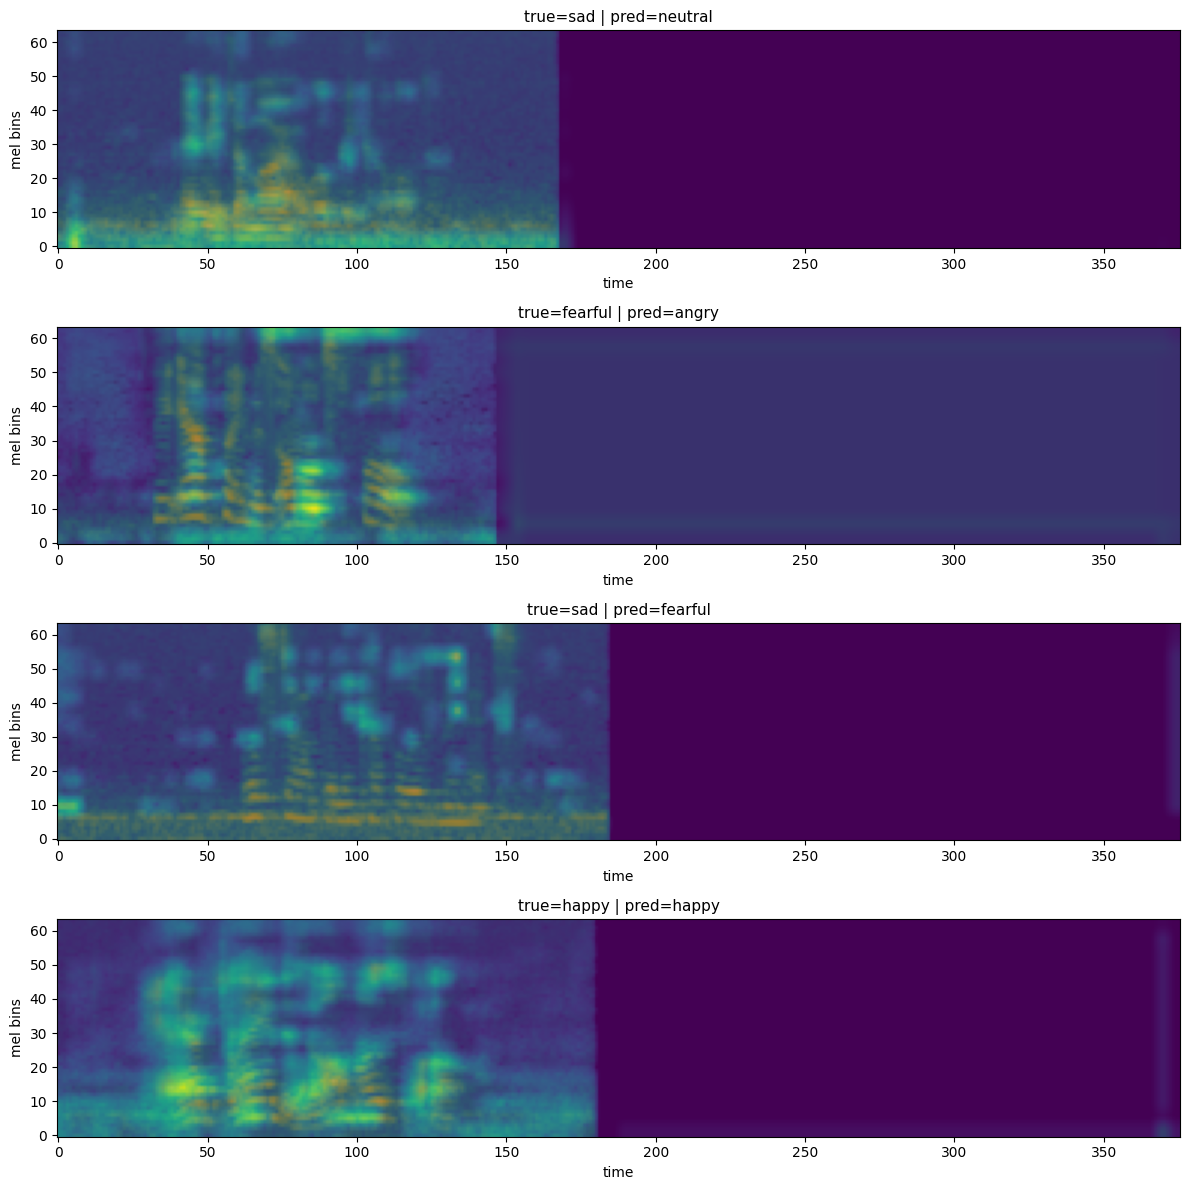


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.6852    0.6201    0.6510       179
       happy     0.6648    0.5667    0.6118       210
         sad     0.5187    0.5952    0.5543       210
       angry     0.7342    0.7762    0.7546       210
     fearful     0.5507    0.5952    0.5721       210
     disgust     0.5556    0.5238    0.5392       210

    accuracy                         0.6127      1229
   macro avg     0.6182    0.6129    0.6139      1229
weighted avg     0.6165    0.6127    0.6129      1229


VISUAL ANALYSIS – CREMA-D – FOLD 5


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

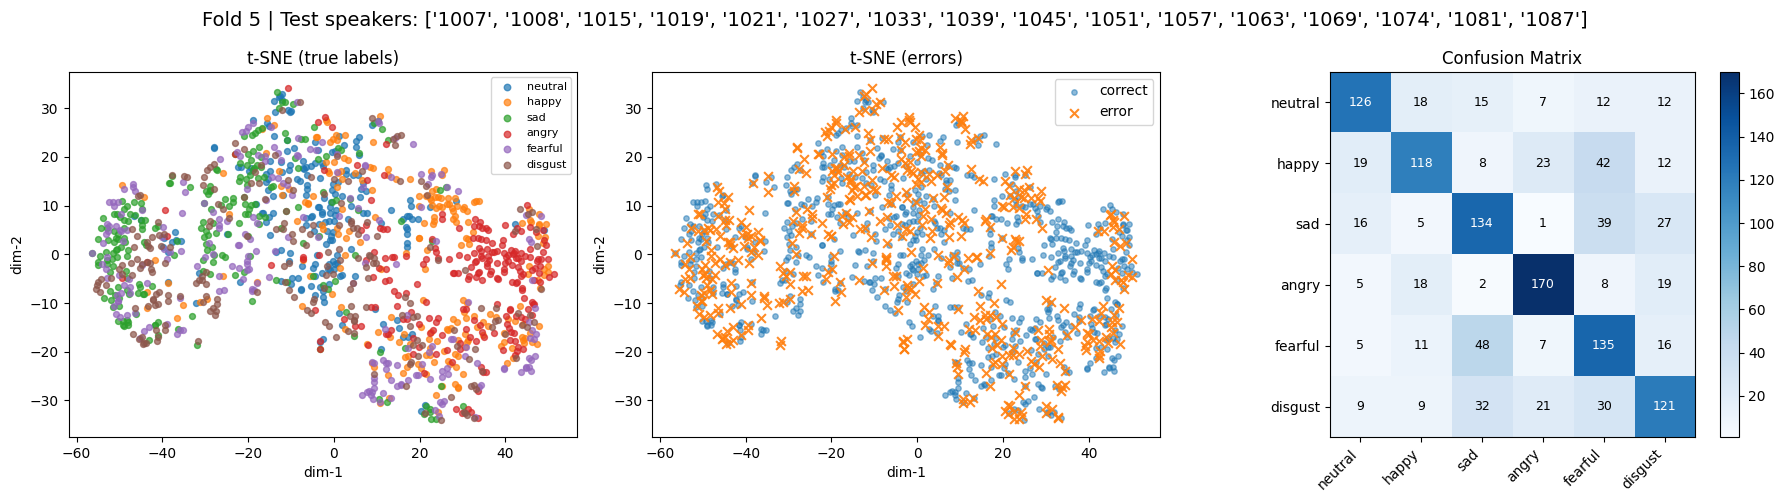

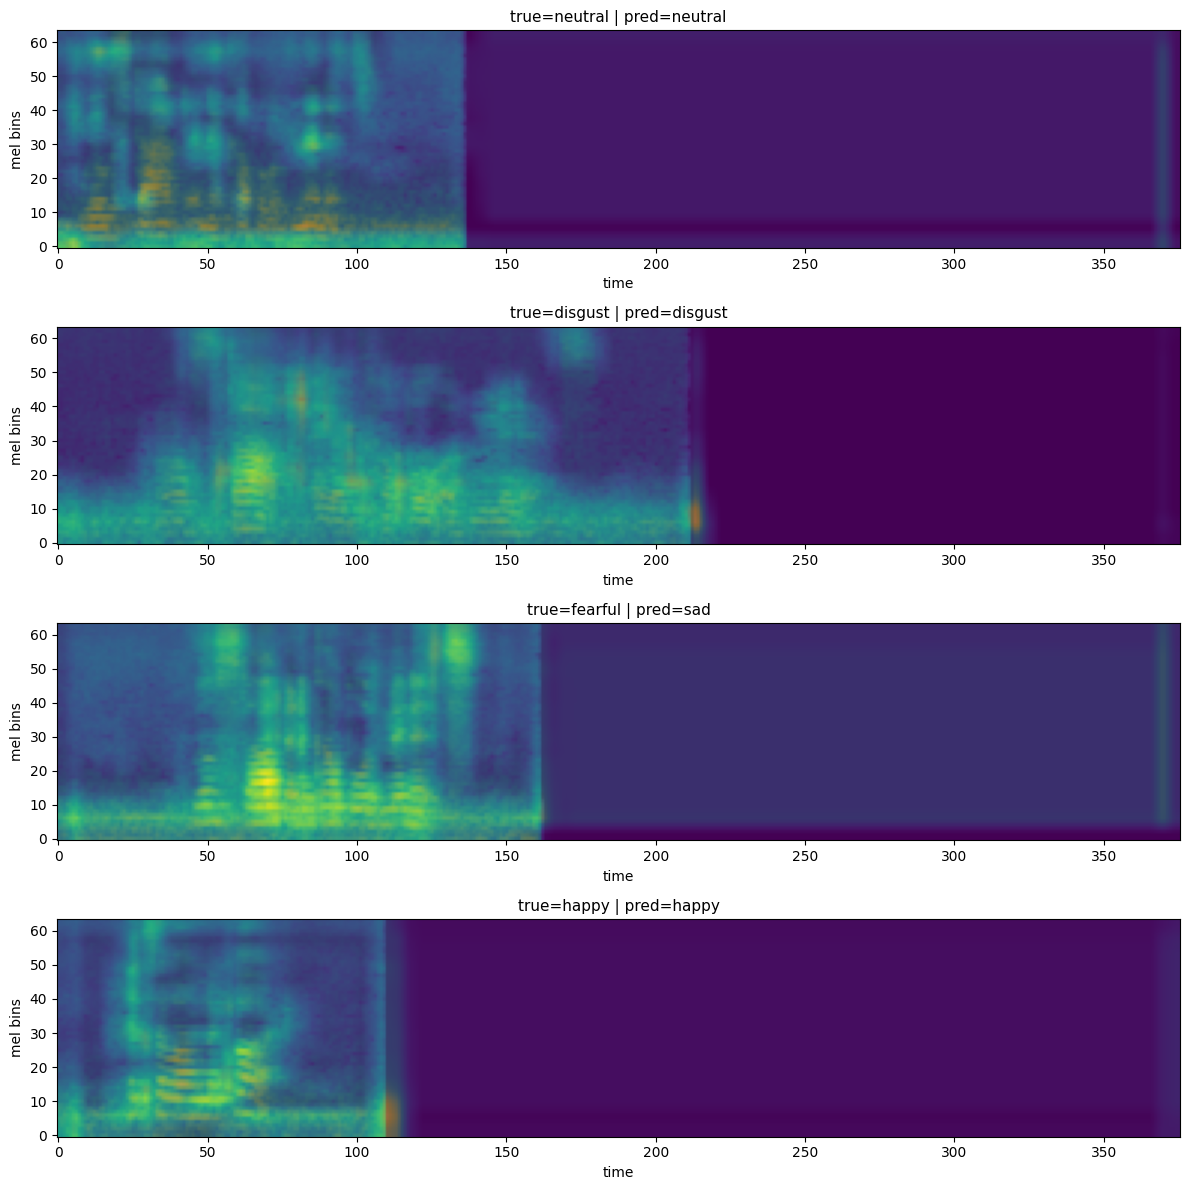


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.7000    0.6632    0.6811       190
       happy     0.6592    0.5315    0.5885       222
         sad     0.5607    0.6036    0.5813       222
       angry     0.7424    0.7658    0.7539       222
     fearful     0.5075    0.6081    0.5533       222
     disgust     0.5845    0.5450    0.5641       222

    accuracy                         0.6185      1300
   macro avg     0.6257    0.6195    0.6204      1300
weighted avg     0.6239    0.6185    0.6189      1300


VISUAL ANALYSIS – CREMA-D – FOLD 6


C:\Users\franc\AppData\Local\Temp\ipykernel_26812\843342953.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt"

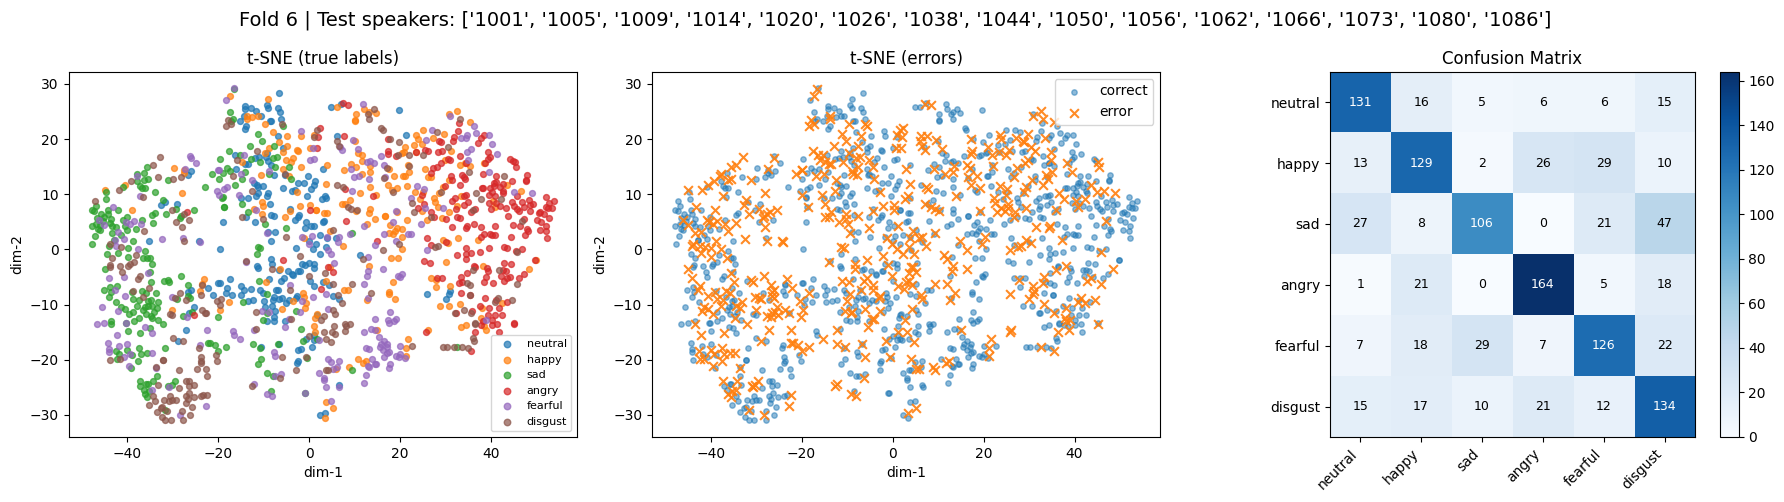

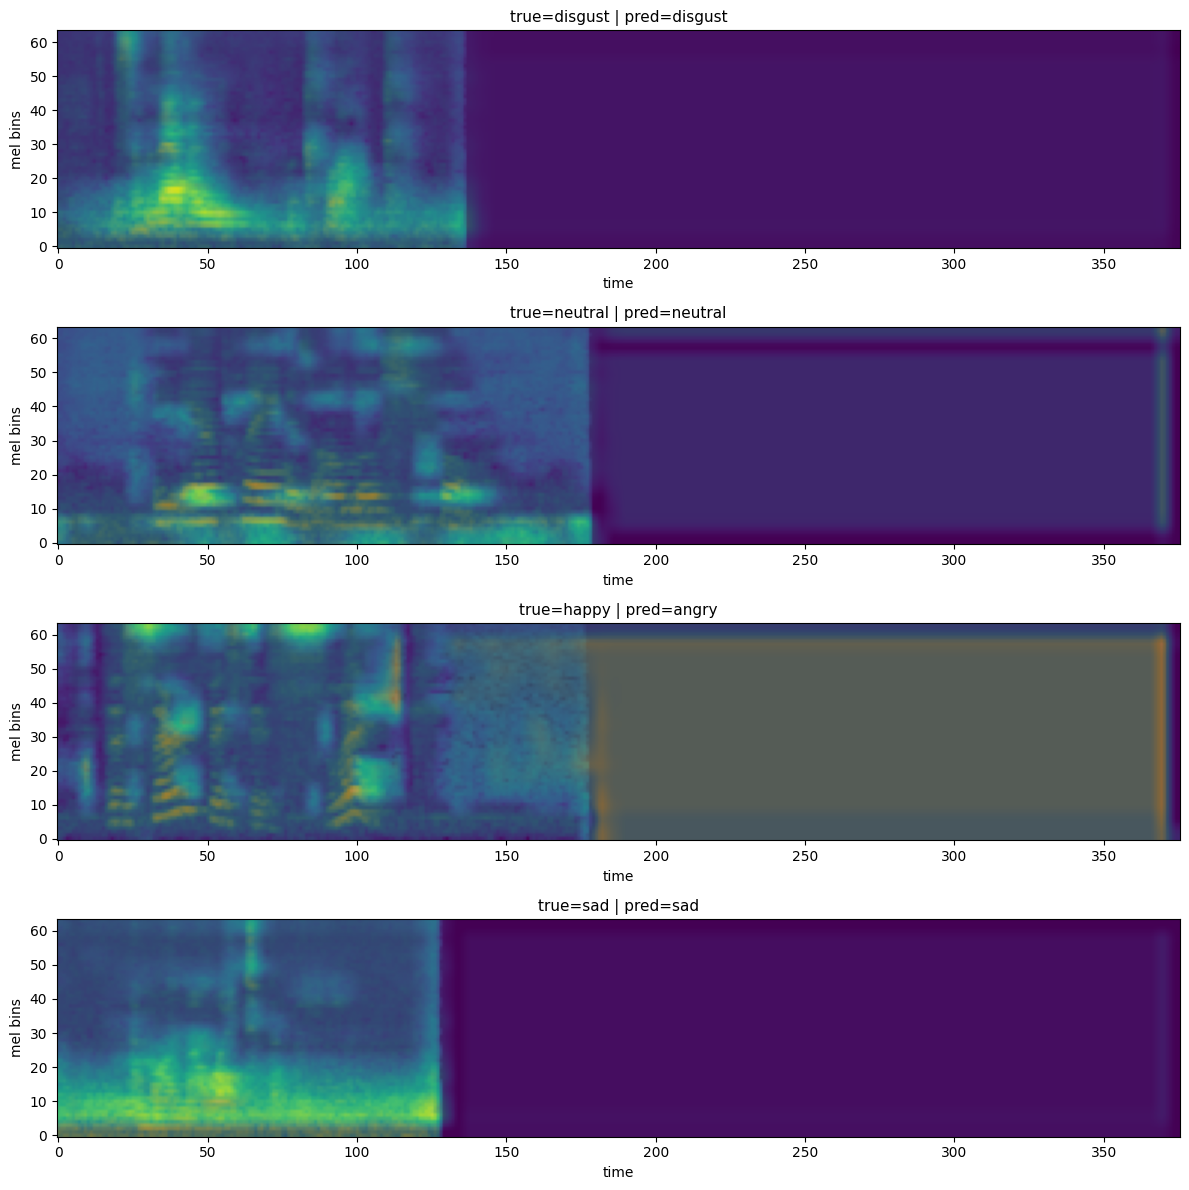


Classification report fold:
              precision    recall  f1-score   support

     neutral     0.6753    0.7318    0.7024       179
       happy     0.6172    0.6172    0.6172       209
         sad     0.6974    0.5072    0.5873       209
       angry     0.7321    0.7847    0.7575       209
     fearful     0.6332    0.6029    0.6176       209
     disgust     0.5447    0.6411    0.5890       209

    accuracy                         0.6454      1224
   macro avg     0.6500    0.6475    0.6452      1224
weighted avg     0.6494    0.6454    0.6438      1224



In [15]:
# =====================================================
# STEP VISUALIZZAZIONI (CREMA-D) - DOPO TUTTI I FOLD
# =====================================================
print(f"\n{'='*70}")
print(f"RISULTATI FINALI CROSS-VALIDATION ({N_FOLDS} FOLDS) - CREMA-D")
print(f"{'='*70}\n")

test_accs = [r["final_test_acc"] for r in fold_results]
val_accs  = [r["best_val_acc"] for r in fold_results]

print("Risultati per fold:")
print(f"{'Fold':<6} {'Val Acc':<10} {'Test Acc':<10} {'Test Speakers'}")
print("-" * 70)
for r in fold_results:
    print(f"{r['fold']+1:<6} {r['best_val_acc']:<10.4f} {r['final_test_acc']:<10.4f} {r['test_speakers']}")

print("\n" + "=" * 70)
print(f"MEDIA ± STD:")
print(f"  Validation Acc: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"  Test Acc:       {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print("=" * 70)

# 1) Plot accuracy per fold + confronto finale
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
axes = axes.flatten()

for idx, r in enumerate(fold_results):
    ax = axes[idx]
    epochs_range = range(1, len(r["val_acc_history"]) + 1)
    ax.plot(epochs_range, r["val_acc_history"], label="Val", linewidth=2)
    ax.plot(epochs_range, r["test_acc_history"], label="Test", linewidth=2)
    ax.set_title(f"Fold {r['fold']+1} (Test speakers: {r['test_speakers']})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.75, color="r", linestyle="--", alpha=0.5)

ax = axes[-1]
x_pos = np.arange(N_FOLDS)
ax.bar(x_pos, test_accs, alpha=0.7, label="Test Acc")
ax.axhline(y=np.mean(test_accs), color="r", linestyle="--", label=f"Mean: {np.mean(test_accs):.3f}")
ax.axhline(y=0.75, color="g", linestyle="--", label="Target: 0.75")
ax.set_xlabel("Fold")
ax.set_ylabel("Test Accuracy")
ax.set_title("Test Accuracy Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels([f"F{i+1}" for i in range(N_FOLDS)])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2) Confusion matrix aggregata
all_y_true, all_y_pred = [], []
for r in fold_results:
    all_y_true.extend(r["y_true"])
    all_y_pred.extend(r["y_pred"])

cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(9, 7))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix Aggregata (Tutti i Fold) - CREMA-D", fontsize=14)
plt.colorbar()

tick_marks = np.arange(6)
target_names = [CREMA_IDX2LABEL[i] for i in range(6)]
plt.xticks(tick_marks, target_names, rotation=45, ha="right")
plt.yticks(tick_marks, target_names)

thresh = cm.max() / 2. if cm.max() > 0 else 0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

print("\nClassification Report Aggregato (Tutti i Fold) - CREMA-D:")
print(classification_report(all_y_true, all_y_pred, target_names=target_names, digits=4))

# =====================================================
# VISUAL ANALYSIS (t-SNE + Grad-CAM) - DOPO VISUALIZZAZIONI
# =====================================================
print("\n" + "=" * 80)
print("VISUAL ANALYSIS (t-SNE + Grad-CAM) - CREMA-D")
print("=" * 80)

# Rigenero gli split per ricostruire test_idx a fold (stesso seed e stesso GroupKFold)
splits = list(gkf.split(all_files, labels, groups=speakers))

for fold_idx in range(N_FOLDS):
    print("\n" + "=" * 80)
    print(f"VISUAL ANALYSIS – CREMA-D – FOLD {fold_idx + 1}")
    print("=" * 80)

    _, test_idx = splits[fold_idx]
    test_files = [all_files[i] for i in test_idx]
    test_speakers = sorted({speakers[i] for i in test_idx})

    test_ds = CremadDataset(test_files, n_mels=N_MELS, augmentation=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    model = CRNN(n_classes=6, n_mels=N_MELS).to(device)
    model.load_state_dict(torch.load(f"best_fold_{fold_idx}.pt", map_location=device))
    model.eval()

    emb, y_true_e, y_pred_e = extract_crnn_embeddings(model, test_loader, device)
    Z = tsne_project(emb, pca_dim=50, perplexity=30, seed=42)

    plot_fold_summary(Z, y_true_e, y_pred_e, fold_idx, test_speakers)
    gradcam_summary(model, test_loader, device, n_examples=4, seed=42)

    print("\nClassification report fold:")
    print(classification_report(
        y_true_e, y_pred_e,
        target_names=[CREMA_IDX2LABEL[i] for i in range(6)],
        digits=4
    ))